In [15]:
import datetime
import netCDF4
import xarray as xr
import matplotlib as mpl
import cdsapi
import numpy as np
import warnings
import regionmask
import matplotlib.pyplot as plt
import pandas as pd
warnings.filterwarnings('ignore')
plt.style.use('default')
import cftime
import os
import seaborn as sns
import cartopy
import cartopy.feature as cpf
from global_land_mask import globe
import CMIP6_light_map
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from shapely.geometry import box, mapping
import geopandas as gpd
import rioxarray
from matplotlib import cm
import cartopy.feature as cpf
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import texttable
from tqdm.notebook import trange, tqdm

In [16]:
def convert_to_180(ds):
    return ds.assign_coords(lon=(((ds.lon + 180) % 360) - 180)).sortby('lon')

def get_area_averaged_ds(fname, model, scenario, ensemble_id, var_name, LME, frequency, models_dict):

    with xr.open_dataset(fname) as ds:
        ds=convert_to_180(ds)
        ds=ds.sel(time=slice(start_time,end_time)) #.sel(lat=slice(min_lat,max_lat), lon=slice(min_lon,max_lon))
        lon_c,lat_c=np.meshgrid(ds.lon.values,ds.lat.values)
        is_in_ocean_c = globe.is_ocean(lat_c,lon_c)
        ds.coords['mask'] = (('lat', 'lon'), is_in_ocean_c)

      #  ds = ds[var_name].where(ds.mask==1).fillna(0)
        ds = ds.resample(time=frequency).mean()
        ds = get_data_within_LME(ds, var_name, LME)
        ds = ds.mean({"lat","lon"})
        df = ds.to_dataframe().dropna()
        df = df.reset_index() #.resample(frequency, on="time").mean()
        df["model"]=model
        df["ensemble_id"]=ensemble_id
        df["scenario"]=scenario
        unique="{}_{}_{}".format(model, scenario, ensemble_id)
        df["unique"]=unique

        model_info={}
        model_info["model_name"]=model
        model_info["model_scenario"]=scenario
        model_info["model_ensemble_id"]=ensemble_id
        model_info["model_var"]=var_name
        key="{}_{}_{}_{}".format(model,ensemble_id,scenario,var_name)
        formatter="{:.2f}"
        model_info["model_hist_min"]=formatter.format(np.nanmin(df[var_name]))
        model_info["model_hist_max"]=formatter.format(np.nanmax(df[var_name]))

        models_dict[key]=model_info

        return df, models_dict

In [18]:
def get_LME_records():
    lme_file='../oceanography/Shapefiles/LME66/LMEs66.shp'
    return gpd.read_file(lme_file)

def get_LME_records_plot():
    lme_file='../oceanography/Shapefiles/LME66_180/LME66_180.shp'
    return gpd.read_file(lme_file)

def create_colors(N):
    color=iter(cm.tab20b(np.linspace(0,1,N)))
    return [next(color) for c in range(N)]

def create_map(df, title, var_name, period, anomalies=False, details=False):
    if details is True:
        lonmin=-165
        lonmax=-143.5
        latmin=53.5
        latmax=65.0
        res="10m"
    else:
        lonmin=-252
        lonmax=-100.5
        latmin=20
        latmax=80
        res="50m"
    ax = plt.figure(figsize=(16,10)).gca(projection=cartopy.crs.PlateCarree(central_longitude=-180))

    ax.coastlines(resolution=res, linewidth=0.6, color="black", alpha=0.8, zorder=4)
    ax.add_feature(cpf.BORDERS, linestyle=':',alpha=0.4)
    ax.add_feature(cpf.LAND, color="lightgrey")
    ax.set_extent([lonmin, lonmax, latmin, latmax])

    xticks = np.linspace(lonmin, lonmax, 5)
    yticks = np.linspace(latmin, latmax, 5)

    ax.set_xticks(xticks, crs=cartopy.crs.PlateCarree())
    ax.set_yticks(yticks, crs=cartopy.crs.PlateCarree())
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)

    #if var_name in ["par"]:
    clb_label='PAR ($W/m^{2}$)'
    cs=ax.contourf(df["lon"], df["lat"], df[var_name], #np.where(df["H"] < 0, df["H"], np.nan), # df[var_name],
                   cmap=sns.color_palette("Spectral_r", as_cmap=True),
                   transform=ccrs.PlateCarree())

    if title not in ["Bathymetry"]:
        clb = plt.colorbar(cs, shrink=0.5, extend="both")

    plt.xlabel("Longitude")
    plt.ylabel("Latitude")

    #if details:
    #    plt.savefig("../../GOA-Laurel/Figures/Bottom_{}_july_sept_250m_zoomed_{}.png".format(var_name, period), dpi=300,
    #                facecolor='w',
    #                transparent=False,
    #                bbox_inches = 'tight',
    #                pad_inches = 0)
    #else:
    #    plt.savefig("../../GOA-Laurel/Figures/Bottom_{}_july_sept_250m_{}.png".format(var_name, period), dpi=300,
    #            facecolor='w',
    #                transparent=False,
    #                bbox_inches = 'tight',
    #                pad_inches = 0)

    plt.show()


def create_LME_figure(ax, LMES, projection, show):

    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.COASTLINE)
    extent = [-252, -100, 10, 65]
    ax.set_extent(extent)

    # Get the -180-180 projected shapefile containing LMEs to make it
    # easy to plot across the Pacific Ocean
    shdf = get_LME_records_plot()
    colors_rgb=create_colors(len(LMES))
    counter=0
    for LME_NAME,LME_NUMBER in zip(shdf['LME_NAME'],shdf['LME_NUMBER']):

        shdf_sel = shdf[ shdf['LME_NAME']==LME_NAME ]

        if (LME_NAME in LMES):
            print("Adding geometry for LME {}".format(LME_NAME))
            # Add the geometry and fill it with color
            if len(LMES)==1:
                color="red"
            else:
                color=colors_rgb[counter]
            ax.add_geometries(shdf_sel['geometry'],
                              projection,
                              facecolor=color,
                              edgecolor='k')

            # Add the label LME_NUMBER of the selected LME at the center of the LME
            ax.annotate(s=LME_NUMBER,
                        xy=(shdf_sel.centroid.x,shdf_sel.centroid.y),
                        color="white",
                        fontsize=13)
            counter+=1
        else:
            ax.add_geometries(shdf_sel['geometry'],
                              projection,
                              facecolor='LightGray',
                              edgecolor='k')

    if show:
        plt.show()

def get_data_within_LME(ds,var_name,LME):

    print("Working on LME: {}".format(LME))

    # Extract the polygon defining the boundaries of the LME
    shdf = get_LME_records()
    shdf_sel = shdf[ shdf['LME_NAME']==LME ]

    # Setup the figure panels
    fig = plt.figure(figsize=(13, 8))
    projection=ccrs.PlateCarree(central_longitude=-180)
    ax1 = fig.add_subplot(111, projection=projection)

    # Create the map of the LME bopundaries and color it.
    # The active LME has color while the others are grey.
    create_LME_figure(ax1, [LME], projection,False)

    # We need to add the projection to the dataset. Lon and lat projections are WGS84 (epsg:4326)
    print(var_name)
    ds.coords['lon'] = (ds.coords['lon'] + 180) % 360 - 180
    ds = ds.sortby(ds.lon)

    # Rioxarray requires x and y dimensions - we convert these back to lon and lat later.
    # We also add the projection (lat-lon) so that rioxarray can do the clipping of the data according to the
    # shapefile.

    tos=ds.rename({'lon': 'x','lat': 'y'})
    tos=tos.rio.write_crs(4326)

    # Clip the data within the LME. We have to convert the polygon geometry to a geodataframe using
    # `shapely.geometry`. The clipping of data within the polygon is done using rioxarray.clip function

    clipped = tos.rio.clip(geometries=shdf_sel.geometry.apply(mapping), crs=tos.rio.crs)
    clipped=clipped.rename({'x': 'lon','y': 'lat'}).to_dataset()

    p1="2000-01-01 to 2020-01-01"
    p2="2080-01-01 to 2020-01-01"

    create_maps=False
    if create_maps:
        clipped_p1=clipped.sel(time=slice("2000-01-01","2020-01-01")).mean({"time"})
       # clipped_p2=clipped.sel(time=slice("2080-01-01","2099-12-16")).mean({"time"})

        create_map(clipped_p1, "{} 2000-01-01 to 2020-01-01".format(var_name), var_name, period=p1, anomalies=False, details=False)
        #create_map(clipped_p2, "{} 2080-01-01 to 2020-01-01".format(var_name), var_name, period=p2, anomalies=False, details=False)

        plt.show()
    return clipped

<xarray.Dataset>
Dimensions:   (expver: 2, lat: 161, lon: 1440, time: 510)
Coordinates:
  * lon       (lon) float32 -180.0 -179.8 -179.5 -179.2 ... 179.2 179.5 179.8
  * lat       (lat) float32 90.0 89.75 89.5 89.25 89.0 ... 50.75 50.5 50.25 50.0
  * expver    (expver) int32 1 5
  * time      (time) datetime64[ns] 1979-01-01 1979-02-02 ... 2021-06-06
Data variables:
    msdwswrf  (time, expver, lat, lon) float32 -1.526e-05 -1.526e-05 ... 176.6
    msdwuvrf  (time, expver, lat, lon) float32 1.907e-06 1.907e-06 ... 21.57
    tcc       (time, expver, lat, lon) float32 0.9604 0.9604 ... 0.915 0.9138
Attributes:
    Conventions:  CF-1.6
    history:      2021-07-08 17:28:45 GMT by grib_to_netcdf-2.20.0: /opt/ecmw...
Working on LME: Gulf of Alaska
msdwswrf <xarray.DataArray 'msdwswrf' (time: 43, expver: 2, lat: 161, lon: 1440)>
array([[[[112.81363  , 112.44494  , 112.08734  , ..., 112.94748  ,
          112.97576  , 112.89496  ],
         [111.96713  , 111.61813  , 111.262566 , ..., 112.1550

TypeError: cannot directly convert an xarray.Dataset into a numpy array. Instead, create an xarray.DataArray first, either with indexing on the Dataset or by invoking the `to_array()` method.

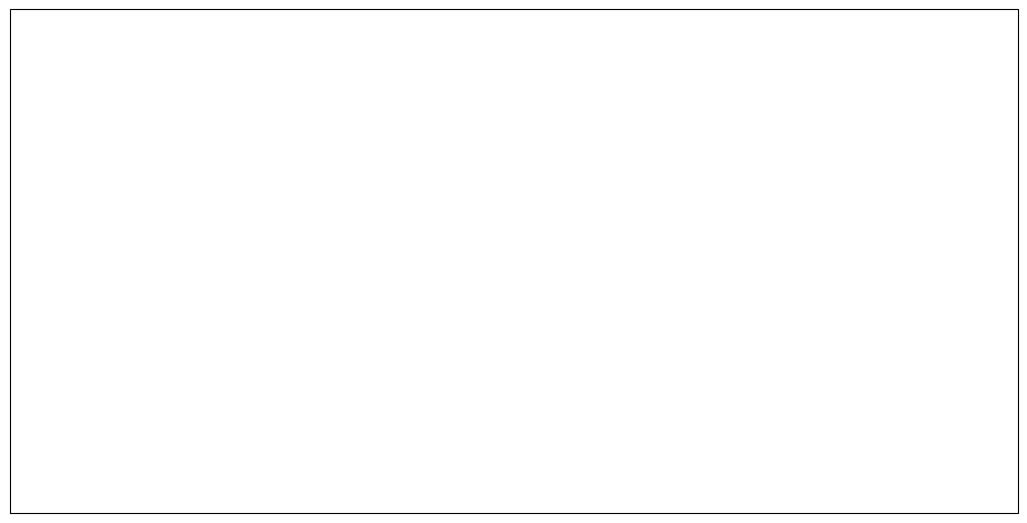

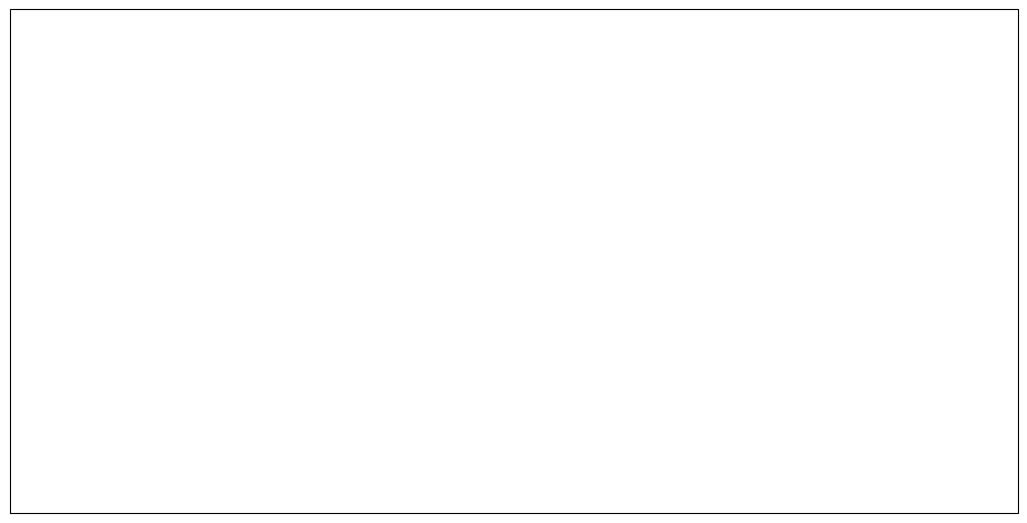

In [19]:
def create_summary_table(dict_of_models):
    table = texttable.Texttable()
    table.set_cols_align(["c", "c", "c", "c","c","c","c","c","c","c"])
    table.set_cols_valign(["t", "m", "m","m","m","m","m","m","m", "b"])

    table.header(["Model", "Scenario", "ID", "Var", "Obs min", "Obs max",  "Obs SD min", "Obs SD max",  "Proj SD min", "Proj SD max"])
    for key in dict_of_models.keys():
        model=dict_of_models[key]

        table.add_row([model["model_name"],
                                                              model["model_scenario"],
                                                              model["model_ensemble_id"],
                                                              str(model["model_var"]),
                                                              str(model["glorys_min"]),
                                                   str(model["glorys_max"]),
                       str(model["model_hist_min"]),
                                                   str(model["model_hist_max"]),
                       str(model["model_proj_min"]),
                           str(model["model_proj_max"])])



    table.set_cols_width([30, 20, 20, 10, 6, 6,6,6,6,6])
    print(table.draw() + "\n")

In [ ]:
%%time
scenarios=["ssp245"]
member_range=2
frequency="A"
ensemble_ids = ["r{}i{}p{}f{}".format(str(i + 1), str(ii + 1), str(iii + 1), str(iv + 1)) for i in
                           range(member_range)
                           for ii in range(member_range) for iii in range(member_range) for iv in range(member_range)]
period="1950-01-01-2099-12-16"
start_time="1950-01-01"
end_time="2099-12-16"

models=["MPI-ESM1-2-HR","CanESM5","ACCESS-ESM1-5","MPI-ESM1-2-HR"]
ds_var_names=["clt"]

LMES=['California Current','East Bering Sea','Gulf of Alaska',
      'Northern Bering - Chukchi Seas','West Bering Sea','Sea of Japan',
      'Oyashio Current','Kuroshio Current','East China Sea',
      'South China Sea','Sea of Okhotsk','Yellow Sea',
      'Aleutian Islands']

LMES=['Gulf of Alaska','Northern Bering - Chukchi Seas']

for var_name in ds_var_names:
    for LME in LMES:
        ds_list=[]
        models_dict={}
        # We loop over all of the scenarios, ensemble_ids, and models to create a
        # list of dataframes that we eventually concatenate together and plot
        for scenario in scenarios:
            for model in models:
                for ensemble_id in ensemble_ids:
                    fname = "../oceanography/cmip6/light/{}/CMIP6_{}_{}_{}_{}.nc".format(scenario,
                                                                                         model,
                                                                                         ensemble_id,
                                                                                         scenario,
                                                                                         var_name)
                    df, models_dict  = get_area_averaged_ds(fname, var_name, LME, frequency, models_dict)
                    ds_list.append(df)

        if len(ds_list) > 0:

            create_summary_table(models_dict)

            sns.set_style("ticks")
            f=plt.figure(figsize=(16, 16), dpi=150)
            gs = f.add_gridspec(2, 1)
            ax = f.add_subplot(gs[0, 0])

            sns.set_palette("tab10")
         #   sns.lineplot(ax=ax, data=df, x=df.index, y=df[var_name], ci=95, alpha=0.95)

            sns.lineplot(ax=ax, data=df, x=df.index, y=df[var_name],
                         hue=df["experiment_id"],
                                     ci=95, alpha=0.95)
            plt.legend()
            plt.ylabel("{}".format(var_name))
            if not os.path.exists("Figures"):
                os.makedirs("Figures")
            plotfile="Figures/CMIP6_lightpaper_{}.png".format(var_name)
            print("Created figure {}".format(plotfile))
            plt.savefig(plotfile, dpi=150,
                        bbox_inches = 'tight')

            plt.show()

        df=pd.DataFrame()
        ds_list=[]